In [5]:
import os

path = os.path.join(os.getcwd(), "img")
images = os.listdir(path)

for i, x in enumerate(images):
    name = f"{path}\\{x}"
    print(name)
    os.rename(name, f"{path}\\fish-{str(i+1)}.jpg")

c:\Users\aron.gimesi\Documents\.codes\sanbox\img\fish-1.jpg
c:\Users\aron.gimesi\Documents\.codes\sanbox\img\fish-2.jpg
c:\Users\aron.gimesi\Documents\.codes\sanbox\img\fish-3.jpg
c:\Users\aron.gimesi\Documents\.codes\sanbox\img\fish-4.jpg


# Imports and helper functions

In [13]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import skimage
import scipy.ndimage as nd 

def imshow_grid(images, nrows=2, ncols=None, figsize=None, cmap='gray', hist=False):
    num_images = len(images)
    
    if ncols is None:
        ncols = int(np.ceil(num_images/nrows))
        
    if figsize is None:
        figsize = (ncols*3, nrows*3)
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        if i < num_images:
            if hist:
                ax.hist(images[i].ravel(), bins=255)
            else:
                ax.imshow(images[i], cmap=cmap)
                ax.axis('off')
                
    plt.tight_layout()
    
    plt.show()

## Hough transform function to find circle

In [26]:
def hough_transformation(img: np.ndarray):
    image = cv.medianBlur(img, 5)  # Apply blur

    # Use Hough transform (might have to change params)
    circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1, 100, param1=50, param2=30,
                              minRadius=int(image.shape[1] / 3),
                              maxRadius=int(image.shape[1]/ 2))

    if len(circles) == 0:
        print("No circles found!")
    return circles


def well_hough_transformation(input_img):
    circles = hough_transformation(input_img)
    circles = np.uint16(np.around(circles))  # Rounding values for int16

    # Selecting first circle
    try:
        circle = circles[0][0]
    except:
        raise Exception("No well found!")
    radius = circle[2]  # Storing circle radius in input object
    center = (circle[0], circle[1])  # Storing circle center in input object

    output_img = cv.cvtColor(input_img, cv.COLOR_GRAY2RGB)

    cv.circle(output_img, center, radius, (0, 255, 0), 7)
    cv.circle(output_img, center, 3, (255, 0, 0), 10)

    return radius, center, output_img

def circ_mask(shape, center, radius):
    x, y = np.meshgrid(np.arange(0, shape[1]), np.arange(0, shape[0]))

    # Compute the distance from each point to the center of the circle
    distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)

    # Create a mask where True values correspond to points within the circle
    mask = distance <= radius

    # Display the mask
    return mask


def mask_from_row(x):
    x = x[1]
    im, c, r = x["img"], x["center"], x["rad"]
    return circ_mask(im.shape, c, r)

## Performing Hough-circles

In [27]:
ims = [plt.imread(f"img\\{i}") for i in images] # OG images

well_ims = [] # Images with drawn center and circle

df = pd.DataFrame(columns=["img", "rad", "center"])

for i, im in enumerate(ims):
    rad, c, out = well_hough_transformation(im)
    df.loc[len(df)] = {"img": out, "rad": rad, "center": c}
    well_ims.append(out)

## Masking out the unneeded bg

In [28]:
masks = [mask_from_row(i) for i in df.iterrows()]
maskeds = [np.bitwise_and(image, ims[i]) for i,image in enumerate(masks)]

maskeds = [image * ims[i] for i,image in enumerate(masks)]
maskeds_ = maskeds.copy()

## Step Results


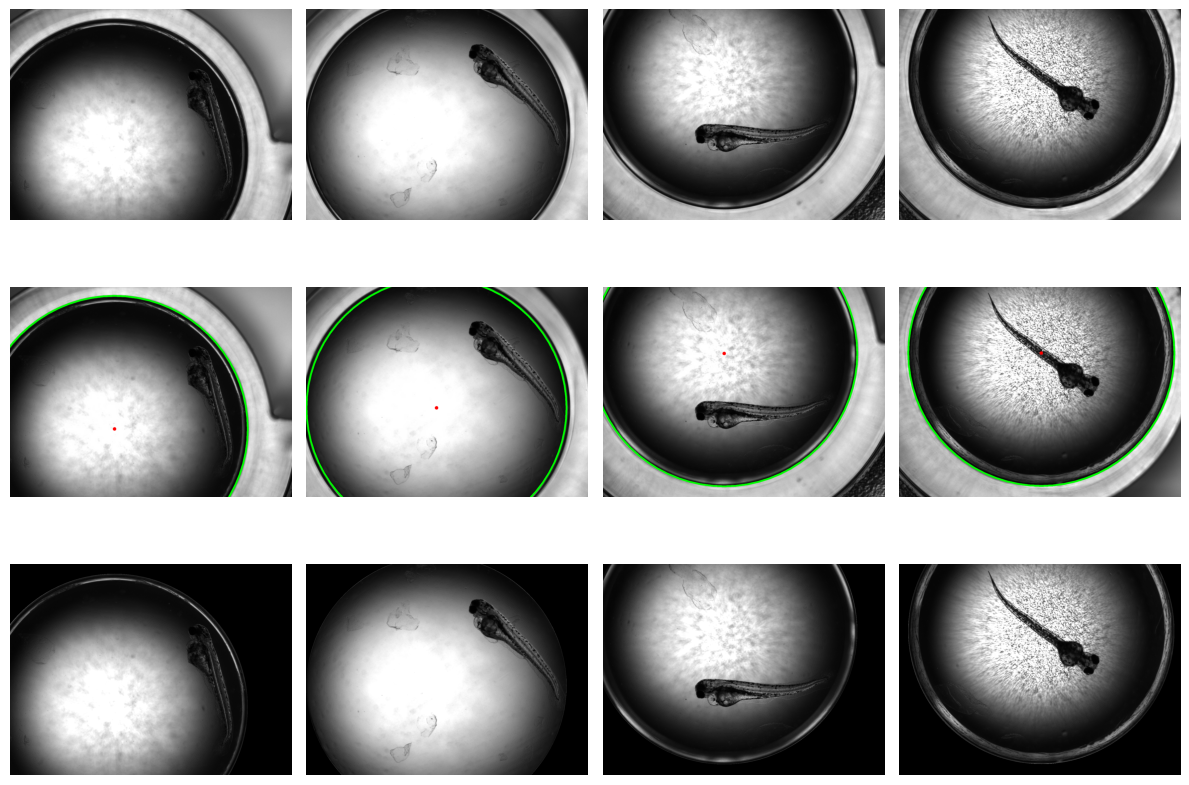

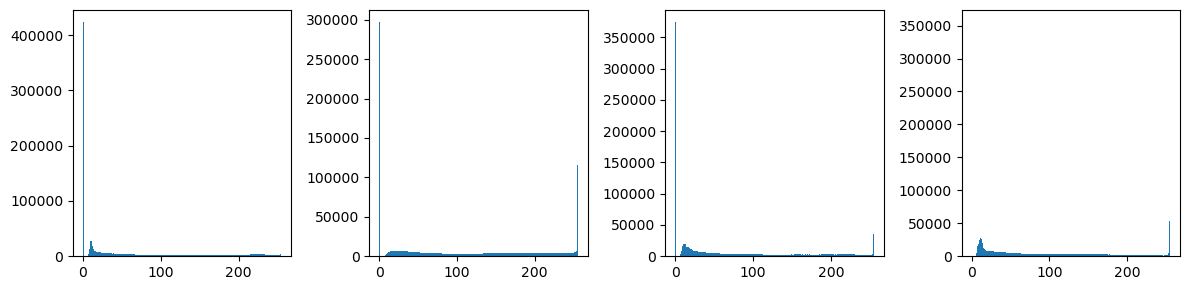

In [29]:
imshow_grid([*ims,*well_ims,*maskeds], nrows=3)
imshow_grid([*maskeds], nrows=1, hist=True)

In [11]:
print(df["img"].apply(lambda x: (np.array(x.shape)[0:2] / 2).astype(int)))
print(df["center"].apply(lambda x: x))
print(df["rad"].apply(lambda x: x))

0    [520, 694]
1    [520, 694]
2    [520, 694]
3    [520, 694]
Name: img, dtype: object
0    (514, 704)
1    (642, 600)
2    (596, 332)
3    (700, 330)
Name: center, dtype: object
0    656
1    640
2    655
3    655
Name: rad, dtype: int64


## Illumination correction

In [12]:
def ill_corr(img):
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    gray = img if len(img.shape) == 2 else cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    print(img.shape)
    print(img.dtype)

    gray = cv.fastNlMeansDenoisingColored(img, None, 25, 20, 21)

    # Compute histogram of grayscale image
    hist, bins = np.histogram(gray.flatten(), 256, [0, 256])

    # Compute cumulative distribution function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Compute inverse CDF
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')

    # Apply the inverse CDF to the grayscale image
    equalized = cv.LUT(gray, cdf)

    # Apply a Gaussian blur to smooth the image
    blurred = cv.GaussianBlur(equalized, (15, 15), 0)

    # Subtract the blurred image from the equalized image
    result = cv.subtract(equalized, blurred)
    return result


(1040, 1388, 3)
uint8
(1040, 1388, 3)
uint8
(1040, 1388, 3)
uint8
(1040, 1388, 3)
uint8


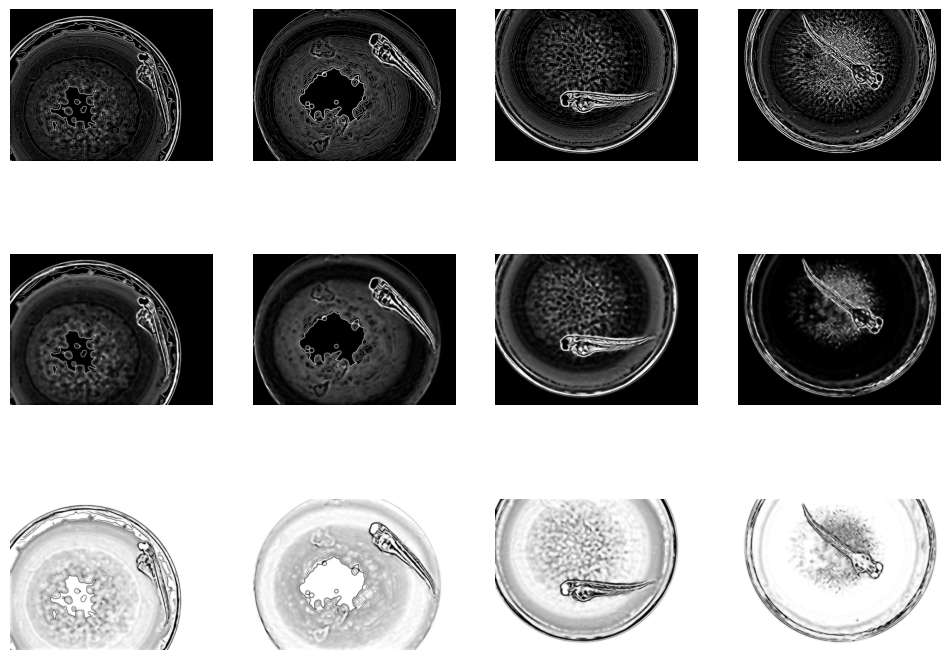

In [21]:
ill_corrs = [ill_corr(i) for i in maskeds]

equalized = [cv.equalizeHist(cv.cvtColor(i, cv.COLOR_BGR2GRAY)) for i in ill_corrs]

ill_corrs1 = []
for i in equalized:
    cop = i.copy()
    m = np.mean(cop) * 4
    cop[cop > m] = 255
    cop[cop <= m] = 0
    cop = cv.fastNlMeansDenoising(cop, None, m, templateWindowSize=7, searchWindowSize=21)
    
    ill_corrs1.append(cop)

imshow_grid([*equalized,*ill_corrs1,*list(map(lambda x: ~x, ill_corrs1))], 3)

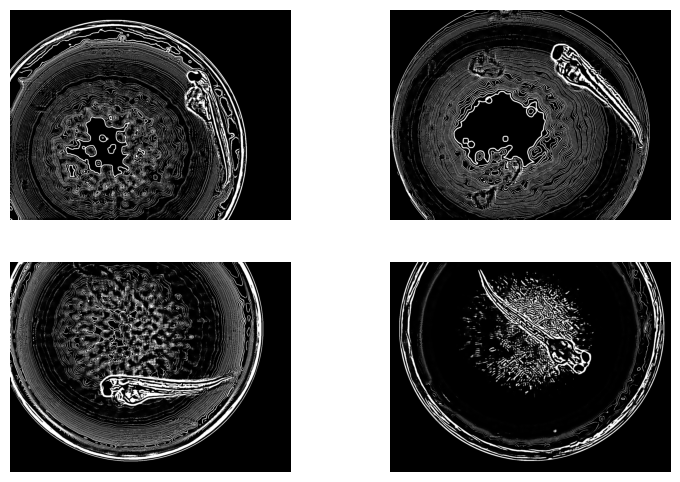

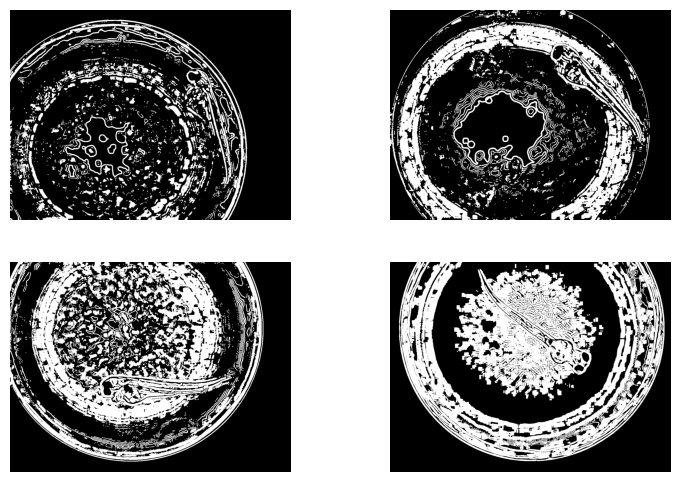

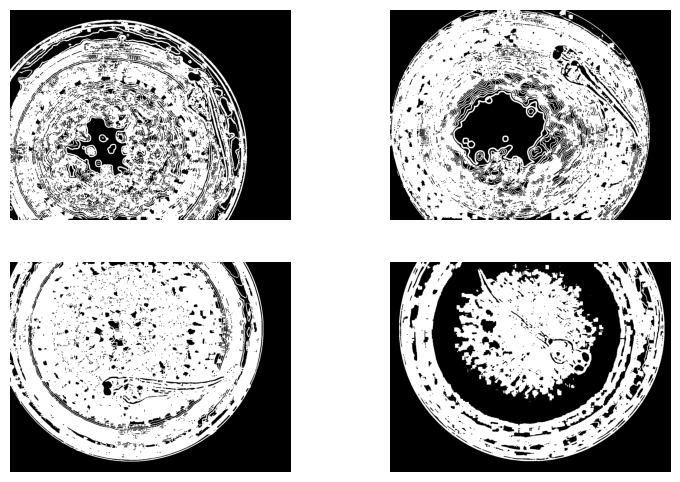

In [34]:
# imshow_grid(ill_corrs, figsize=(9,6), hist=True)
# imshow_grid(ill_corrs, figsize=(9,6))
openeds = [skimage.morphology.binary_opening(i, skimage.morphology.square(3)) for i in ill_corrs1]
closeds = [skimage.morphology.binary_closing(i, skimage.morphology.square(3)) for i in ill_corrs1]
imshow_grid(ill_corrs1, figsize=(9,6))
imshow_grid(openeds, figsize=(9,6))
imshow_grid(closeds, figsize=(9,6))


## FFT Denoise func

## FastNlMeans denoising sandbox

In [ ]:
# title_window = "Linear Blend"

# tws = 18
# sws = 21
# h = 10

# img = ims[0].copy()

# print(img.shape)
# new_size = (tuple((np.array(img.shape) / 2).astype(int)))
# new_size = new_size[::-1]


# img = cv.resize(img, new_size)
# print(img.shape)

# def on_trackbar1(val):
#     global img, tws, sws, h
    
#     if val % 2 == 0:
#         val += 1
#     tws = val

#     dst =  cv.fastNlMeansDenoising(img, None, h, templateWindowSize=tws, searchWindowSize=sws)
#     cv.imshow(title_window, dst)

# def on_trackbar2(val):
#     global img, sws, tws, h

#     if val % 2 == 0:
#         val += 1
#     sws = val

#     dst =  cv.fastNlMeansDenoising(img, None, h, templateWindowSize=tws, searchWindowSize=sws)
#     cv.imshow(title_window, dst)

# def on_trackbar3(val):
#     global img, sws, tws, h

#     if val % 2 == 0:
#         val += 1
#     h = val
    
#     dst =  cv.fastNlMeansDenoising(img, None, h, templateWindowSize=tws, searchWindowSize=sws)
#     cv.imshow(title_window, dst)

# cv.namedWindow(title_window)
# cv.namedWindow(title_window)
# cv.imshow(title_window, cv.fastNlMeansDenoising(img, None, h, templateWindowSize=tws, searchWindowSize=sws))

# cv.createTrackbar("templateWindowSize", title_window , tws, 50, on_trackbar1)
# cv.createTrackbar("searchWindowSize", title_window , sws, 50, on_trackbar2)
# cv.createTrackbar("h", title_window , h, 50, on_trackbar3)


# cv.waitKey(0)
# cv.destroyAllWindows()

In [ ]:
# import time
# def op_cv(image):
#     title_window = "Linear Blend"

#     tws = 7
#     sws = 21
#     h = 25
#     denoised = cv.fastNlMeansDenoising(image, None, h, templateWindowSize=7, searchWindowSize=21)
    
#     # image = cv.GaussianBlur(image, blur_kernel, 0)

#     print(image.shape)
#     new_size = (tuple((np.array(image.shape) / 2).astype(int)))
#     new_size = new_size[::-1]


#     image = cv.resize(image, new_size)
#     print(image.shape)

#     def on_trackbar1(val):
#         if val % 2 == 0:
#             val += 1
#         tws = val
        
#         cv.imshow(title_window, denoised)
#         cv.waitKey(1000)
#         dst = cv.Canny(denoised, sws, tws)
#         cv.imshow(title_window, dst)

#     def on_trackbar2(val):
#         if val % 2 == 0:
#             val += 1
#         sws = val        
        
#         cv.imshow(title_window, denoised)
#         cv.waitKey(1000)
#         dst = cv.Canny(denoised, sws,  tws)
#         cv.imshow(title_window, dst)
        
#     cv.namedWindow(title_window)
#     cv.namedWindow(title_window)
#     cv.imshow(title_window, image)

#     cv.createTrackbar("templateWindowSize", title_window , 0, 250, on_trackbar1)
#     cv.createTrackbar("searchWindowSize", title_window , 0, 250, on_trackbar2)
#     on_trackbar1(7)


#     cv.waitKey(0)
#     cv.destroyAllWindows()
    
# for i in ims:
#     op_cv(i)

## wavelet filter

In [ ]:
from cwt2d import *

cwt = CWT2Filter((1040, 1388),"mexican_hat", 4, 10**10)
cwts = [np.real(cwt(i)) for i in maskeds]
sob1 = [cv.equalizeHist(skimage.filters.sobel(cv.cvtColor(i, cv.COLOR_GBR2GRAY),)) for i in maskeds]
sob2 = [skimage.filters.sobel(i,) for i in cwts]
imshow_grid(sob1)
imshow_grid(sob2)

AttributeError: module 'cv2' has no attribute 'COLOR_BRG2GRAY'

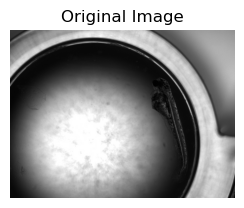

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

gamma_correcteds = []

def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv.LUT(src, table)

def display_image_with_linearization(image, gamma=2.2, dst=None):
    # Display the original image
    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap="brg")
    plt.title('Original Image')
    plt.axis('off')

    # Apply inverse gamma correction to linearize the image
    linearized_image = np.real(gammaCorrection(image, gamma)).astype(np.uint8)
    cv.cvtColor(linearized_image, cv.COLOR_BRG2GRAY)
    print(linearized_image.shape)
    print(linearized_image.dtype)
    linearized_image = cv.equalizeHist(linearized_image)
    
    print(type(dst) == "list")
    
    if dst is not None and type(dst) == "list":
        dst.append(linearized_image)
    
    # Display the linearized image
    plt.subplot(2, 2, 2)
    plt.imshow(linearized_image.astype(np.uint8), cmap="brg")
    plt.title('Linearized Image')
    plt.axis('off')

    # Calculate and display the histogram of the original image
    plt.subplot(2, 2, 3)
    plt.hist(image.flatten(), bins=256, color='gray')
    plt.title('Histogram (Original Image)')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    # Calculate and display the histogram of the linearized image
    plt.subplot(2, 2, 4)
    plt.hist(linearized_image.flatten(), bins=256, color='gray')
    plt.title('Histogram (Linearized Image)')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()



display_image_with_linearization(cv.imread("img/fish-1.jpg"))
display_image_with_linearization(cv.imread("img/fish-2.jpg"))
display_image_with_linearization(cv.imread("img/fish-3.jpg"))
display_image_with_linearization(cv.imread("img/fish-4.jpg"))

In [50]:
import cv2
import numpy as np

# Load the bottom picture
bottom_img = cv2.imread('img/fish-1.jpg', cv2.IMREAD_COLOR)
height, width = bottom_img.shape[:2]

# Load the overlay image
overlay_img = cv2.imread('img/fish-2.jpg', cv2.IMREAD_GRAYSCALE)

# Define the center point of the overlay image relative to the bottom picture
overlay_center_x = 200
overlay_center_y = 150

# Calculate the position of the top-left corner of the overlay image
overlay_x = overlay_center_x - overlay_img.shape[1] // 2
overlay_y = overlay_center_y - overlay_img.shape[0] // 2

# Make sure the overlay image stays within the bounds of the bottom picture
overlay_x = max(overlay_x, 0)
overlay_y = max(overlay_y, 0)
overlay_x_end = min(overlay_x + overlay_img.shape[1], width)
overlay_y_end = min(overlay_y + overlay_img.shape[0], height)

# Create a region of interest (ROI) on the bottom picture
bottom_roi = bottom_img[overlay_y:overlay_y_end, overlay_x:overlay_x_end]

# Resize the overlay image to match the size of the ROI
overlay_resized = cv2.resize(overlay_img, (bottom_roi.shape[1], bottom_roi.shape[0]))

# Convert the overlay image to BGR format for proper blending
overlay_bgr = cv2.cvtColor(overlay_resized, cv2.COLOR_GRAY2BGR)

# Blend the overlay image onto the bottom picture using alpha blending
alpha = 0.5  # Adjust the alpha value as desired
overlay_blend = cv2.addWeighted(bottom_roi, 1 - alpha, overlay_bgr, alpha, 0)

# Replace the ROI with the blended overlay image
bottom_img[overlay_y:overlay_y_end, overlay_x:overlay_x_end] = overlay_blend

# Save the result
cv2.imwrite('result_image.jpg', bottom_img)

True